In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

In [ ]:
def mobilenet_block(x, filters, strides):
  x = DepthwiseConv2D(kernel_size=3 , strides = strides, padding= 'same')(x)
  x= BatchNormalization()(x)
  x= ReLU()(x)

  x=Conv2D(filters=filters, kernel_size=1 , strides = 1)(x)
  x= BatchNormalization()(x)
  x= ReLU()(x)

  return x


In [ ]:
#creat mobilenet model
#first layer of table
input = Input(shape=(224,224,3))
x = Conv2D(filters = 32, kernel_size=3, strides=2, padding='same')(input)
x= BatchNormalization()(x)
x= ReLU()(x)

#main part
x= mobilenet_block(x, filters=64, strides=1)

x= mobilenet_block(x, filters=128, strides=2)
x= mobilenet_block(x, filters=128, strides=1)

x= mobilenet_block(x, filters=256, strides=2)
x= mobilenet_block(x, filters=256, strides=1)

x= mobilenet_block(x, filters=512, strides=2)
for i in range(5):
  x= mobilenet_block(x, filters=512, strides=1)

x= mobilenet_block(x, filters=1024, strides=2)
x= mobilenet_block(x, filters=1024, strides=1)  

x= AvgPool2D(pool_size=7, strides=1)(x)
x= Flatten()(x)
output = Dense(units=1000, activation='softmax')(x)

In [ ]:
#build model
from tensorflow.keras import Model
 
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  91.3M      0  0:00:08  0:00:08 --:--:-- 97.3M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os
import tensorflow as tf

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


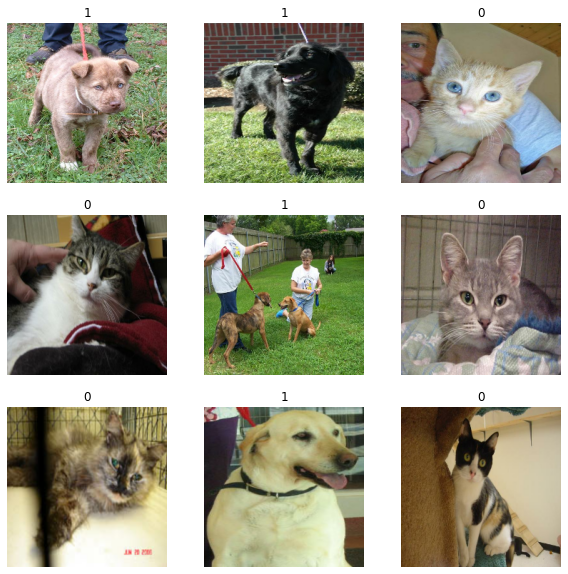

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

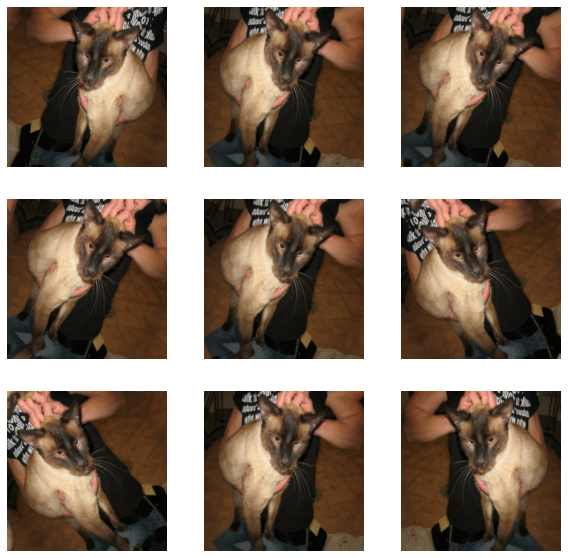

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 148s 220ms/step - loss: 0.6900 - accuracy: 0.6405 - val_loss: 1.1692 - val_accuracy: 0.4957
Epoch 2/50
586/586 [==============================] - 127s 217ms/step - loss: 0.5166 - accuracy: 0.7463 - val_loss: 0.7027 - val_accuracy: 0.6448
Epoch 3/50
586/586 [==============================] - 128s 218ms/step - loss: 0.4342 - accuracy: 0.7998 - val_loss: 0.5370 - val_accuracy: 0.7386
Epoch 4/50
586/586 [==============================] - 128s 218ms/step - loss: 0.3486 - accuracy: 0.8456 - val_loss: 0.3476 - val_accuracy: 0.8492
Epoch 5/50
586/586 [==============================] - 130s 222ms/step - loss: 0.2764 - accuracy: 0.8812 - val_loss: 0.3279 - val_accuracy: 0.8738
Epoch 6/50
586/586 [==============================] - 128s 217ms/step - loss: 0.2284 - accuracy: 0.9027 - val_loss: 0.2775 - val_accuracy: 0.8804
Epoch 7/50
586/586 [==============================] - 128s 217ms/step - loss: 0.1938 - accuracy: 0.9194 - val_loss: 0.3552 -

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]


In [ ]:
score[0]

0.9999999

In [ ]:
score[1]

7.546382e-08

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

In [ ]:
score[0]

2.2479683e-10

In [ ]:
score[1]

1.0

In [ ]:
#VGG16
import tensorflow as tf

vgg16Model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
vgg16Model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
vgg16Model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 300s 493ms/step - loss: 4.4709 - accuracy: 0.5586 - val_loss: 0.6335 - val_accuracy: 0.6512
Epoch 2/10
586/586 [==============================] - 283s 482ms/step - loss: 0.6142 - accuracy: 0.6658 - val_loss: 0.5502 - val_accuracy: 0.7266
Epoch 3/10
586/586 [==============================] - 284s 484ms/step - loss: 0.5612 - accuracy: 0.7174 - val_loss: 0.5302 - val_accuracy: 0.7576
Epoch 4/10
586/586 [==============================] - 284s 485ms/step - loss: 0.4886 - accuracy: 0.7679 - val_loss: 0.4137 - val_accuracy: 0.8210
Epoch 5/10
586/586 [==============================] - 284s 484ms/step - loss: 0.5362 - accuracy: 0.7344 - val_loss: 0.5280 - val_accuracy: 0.7437
Epoch 6/10
586/586 [==============================] - 285s 485ms/step - loss: 0.4913 - accuracy: 0.7656 - val_loss: 0.4763 - val_accuracy: 0.7736
Epoch 7/10
586/586 [==============================] - 286s 487ms/step - loss: 0.4280 - accuracy: 0.8062 - val_loss: 0.4232 -

In [ ]:
vgg16Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#resnet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

ResNet50_model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
ResNet50_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
ResNet50_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9173

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 231s 380ms/step - loss: 0.2353 - accuracy: 0.9173 - val_loss: 0.5465 - val_accuracy: 0.7320
Epoch 2/10
586/586 [==============================] - 221s 376ms/step - loss: 0.1286 - accuracy: 0.9469 - val_loss: 0.4339 - val_accuracy: 0.7879
Epoch 3/10
586/586 [==============================] - 221s 377ms/step - loss: 0.1120 - accuracy: 0.9565 - val_loss: 0.2702 - val_accuracy: 0.8787
Epoch 4/10
586/586 [==============================] - 221s 377ms/step - loss: 0.0926 - accuracy: 0.9618 - val_loss: 0.3966 - val_accuracy: 0.8488
Epoch 5/10
586/586 [==============================] - 221s 377ms/step - loss: 0.0793 - accuracy: 0.9683 - val_loss: 0.2858 - val_accuracy: 0.8926
Epoch 6/10
586/586 [==============================] - 221s 377ms/step - loss: 0.0693 - accuracy: 0.9722 - val_loss: 0.3236 - val_accuracy: 0.8558
Epoch 7/10
586/586 [==============================] - 221s 376ms/step - loss: 0.0625 - accuracy: 0.9769 - val_loss: 0.2345 - val_accura

In [ ]:
ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#VGG19
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

VGG19model = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
VGG19model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
VGG19model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 342s 580ms/step - loss: 95.5853 - accuracy: 0.5504 - val_loss: 0.6766 - val_accuracy: 0.5692
Epoch 2/10
586/586 [==============================] - 336s 573ms/step - loss: 0.6681 - accuracy: 0.5934 - val_loss: 0.6337 - val_accuracy: 0.6380
Epoch 3/10
586/586 [==============================] - 336s 573ms/step - loss: 0.6302 - accuracy: 0.6420 - val_loss: 0.6118 - val_accuracy: 0.6660
Epoch 4/10
586/586 [==============================] - 337s 575ms/step - loss: 0.5807 - accuracy: 0.6920 - val_loss: 0.5574 - val_accuracy: 0.7108
Epoch 5/10
586/586 [==============================] - 341s 582ms/step - loss: 0.5717 - accuracy: 0.7028 - val_loss: 0.5410 - val_accuracy: 0.7302
Epoch 6/10
586/586 [==============================] - 342s 583ms/step - loss: 0.5546 - accuracy: 0.7148 - val_loss: 0.5334 - val_accuracy: 0.7377
Epoch 7/10
586/586 [==============================] - 341s 581ms/step - loss: 0.5292 - accuracy: 0.7341 - val_loss: 0.4973 

In [ ]:
VGG19model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

InceptionV3_model = InceptionV3(input_tensor= input, weights='imagenet', include_top=True)

96124928/96112376 [==============================] - 2s 0us/step


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
InceptionV3_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
InceptionV3_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 188s 303ms/step - loss: 0.1941 - accuracy: 0.9322 - val_loss: 0.1291 - val_accuracy: 0.9483
Epoch 2/10
586/586 [==============================] - 174s 297ms/step - loss: 0.1061 - accuracy: 0.9575 - val_loss: 0.0878 - val_accuracy: 0.9677
Epoch 3/10
586/586 [==============================] - 174s 297ms/step - loss: 0.0868 - accuracy: 0.9679 - val_loss: 0.1144 - val_accuracy: 0.9519
Epoch 4/10
586/586 [==============================] - 174s 297ms/step - loss: 0.0660 - accuracy: 0.9760 - val_loss: 1.2707 - val_accuracy: 0.6386
Epoch 5/10
586/586 [==============================] - 174s 296ms/step - loss: 0.0633 - accuracy: 0.9769 - val_loss: 0.1149 - val_accuracy: 0.9543
Epoch 6/10
586/586 [==============================] - 174s 297ms/step - loss: 0.0541 - accuracy: 0.9791 - val_loss: 0.0841 - val_accuracy: 0.9673
Epoch 7/10
586/586 [==============================] - 174s 297ms/step - loss: 0.0513 - accuracy: 0.9796 - val_loss: 0.1755 -

In [ ]:
InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 111, 111, 32  96         ['conv2d_14[0][0]']              
 ormalization)                  )                                                      

In [ ]:
%tensorflow_version 2.5


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.5`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
image_size = (299, 299)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [ ]:
xception = tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
xception.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
xception.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

586/586 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9639

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 845s 1s/step - loss: 0.1333 - accuracy: 0.9639 - val_loss: 0.1906 - val_accuracy: 0.9304
